In [1]:
%matplotlib inline
import json
import unicodedata
import random
import calendar
import math
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def clean_unicode(instr):
    """
    Helper to return unicode string as ascii with special characters removed.
    """
    return unicodedata.normalize('NFKD', instr).encode('ascii', 'ignore')

In [3]:
def parse_json(filename, normalize=True):
    with open(filename) as f:
        for line in f:
            out = json.loads(line, encoding='latin-1')
            if normalize:
                temp = {}
                for key in out:
                    try:
                        key = clean_unicode(key)
                    except:
                        key = key
                    try:
                        temp[key] = clean_unicode(out[key])
                    except:
                        temp[key] = out[key]
                out = temp
            yield out
    f.close()

In [4]:
def reservoir_sample(iterator, k):
    """
    Reservoir sampling given an iterable input and k for number of items to be sampled
    """
    iterator = iter(iterator)
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]
    n = k
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item
    return result

In [5]:
def groupby_key(data, key_str):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        key_map[key] = key_map.setdefault(key, [])
        key_map[key].append(datum)
    return key_map

In [6]:
def groupby_key_count(data, key_str, func=None):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        try:
            key = func(key)
        except: 
            key = key
        key_map[key] = key_map.setdefault(key, 0) + 1
    return key_map

In [7]:
def group_time_split(user_array, key, func=None):
    return [[groupby_key_count(time_per, key, func) for time_per in user] for user in user_array]

In [8]:
parsed_red = parse_json('data/reduced_data.txt', normalize=True)
dset = [i for i in parsed_red]

In [16]:
users = groupby_key(dset,'user/profileName')
user_vals = users.values()
user_vals = sorted(user_vals, key=len)
print 'number of users', len(user_vals)

user_vals_split = []
split_timestamp = calendar.timegm(datetime(2009,5,1).timetuple())

for i , posts in enumerate(user_vals):
    pre = [post for post in posts if post.get('review/timeUnix') <= split_timestamp]
    post = [post for post in posts if post.get('review/timeUnix') > split_timestamp]
#     testing only active users in both period
    if len(pre) > 0 and len(post) > 0:
        user_vals_split.append([pre, post])

print 'number of users post split', len(user_vals_split)

number of users 9453
number of users post split 2895


In [17]:
# partition data set
users_top = user_vals_split[int(math.floor(len(user_vals_split)*0.95)):]

# sample_size = math.floor(len(user_vals_split) / 2)
sample_size = len(users_top)
users_sampled = reservoir_sample(user_vals_split, sample_size)

In [53]:
def plot_diff(user_list, func=lambda x: x):
    user_pre = [func(user[0]) for user in user_list]
    user_post = [func(user[1]) for user in user_list]

    np_pre = np.array(user_pre)
    np_post = np.array(user_post)
    np_pm = np_post - np_pre
    print "mean p/m: ", np.mean(np_pm)
    print "median p/m: ", np.median(np_pm)
    print "std p/m: ", np.std(np_pm)

    ind = np.arange(len(np_pm))
    fig, ax = plt.subplots()
    ax.scatter(ind, np_pm, c="grey",s=10,edgecolor='none')
    ax.axhline(y=np.mean(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="blue",linewidth=1.1,zorder=0)
    ax.axhline(y=np.median(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="red",linewidth=1.1,zorder=0)

all user review counts
mean p/m:  -4.87841105354
median p/m:  -4.0
std p/m:  138.31627945

top user review counts 145
mean p/m:  40.3034482759
median p/m:  -12.0
std p/m:  406.566333802

sampled user review counts 145
mean p/m:  -22.6137931034
median p/m:  -7.0
std p/m:  108.990868723



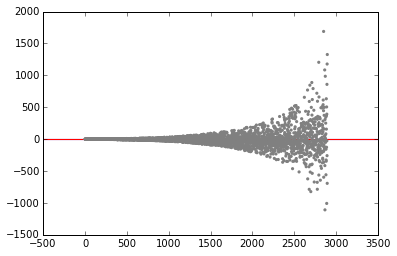

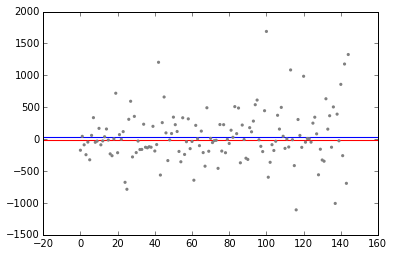

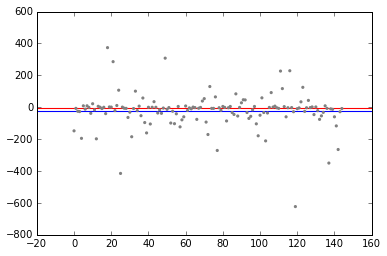

In [54]:
# all users stats
print 'all user review counts'
all_user_revcount = plot_diff(user_vals_split, lambda x: len(x))
print

# top users stats
print 'top user review counts', len(users_top)
top_user_revcount = plot_diff(users_top, lambda x: len(x))
print

# sampled users stats
print 'sampled user review counts', len(users_sampled)
top_user_revcount = plot_diff(users_sampled, lambda x: len(x))
print

all users style counts
mean p/m:  -2.1402417962
median p/m:  -2.0
std p/m:  14.9136033674

top users style counts
mean p/m:  1.11034482759
median p/m:  0.0
std p/m:  9.71817865821

sample users style counts
mean p/m:  -4.08275862069
median p/m:  -3.0
std p/m:  13.0074267636



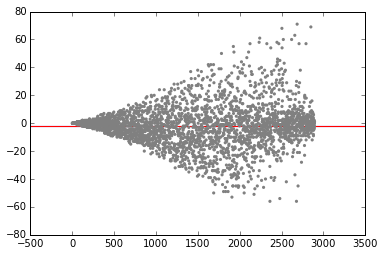

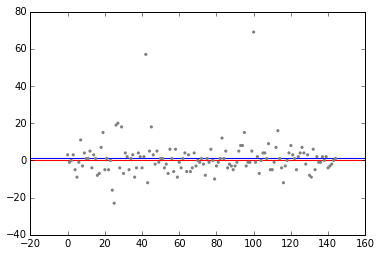

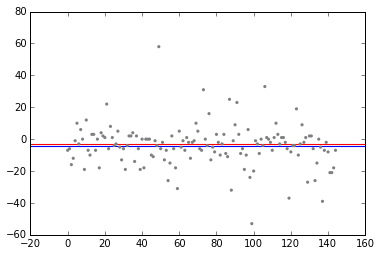

In [55]:
# style before/after
print 'all users style counts'
styles_all = group_time_split(user_vals_split, 'beer/style')
# want number of styles
styles_all = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_all)
styles_all_plot = plot_diff(styles_all)
print

print 'top users style counts'
styles_top = group_time_split(users_top, 'beer/style')
# want number of styles
styles_top = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_top)
styles_top_plot = plot_diff(styles_top)
print

print 'sample users style counts'
styles_samp = group_time_split(users_sampled, 'beer/style')
# want number of styles
styles_samp = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_samp)
styles_samp_plot = plot_diff(styles_samp)
print

all users rating avg
mean p/m:  0.00811008057689
median p/m:  0.00792207792208
std p/m:  0.111136781546

top users rating avg
mean p/m:  0.0101118150359
median p/m:  0.00807444860389
std p/m:  0.0265289893046

sampled users rating avg
mean p/m:  -0.000503492780259
median p/m:  0.00873076923077
std p/m:  0.108562977848



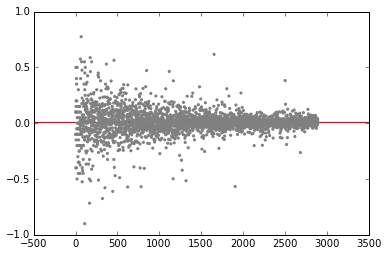

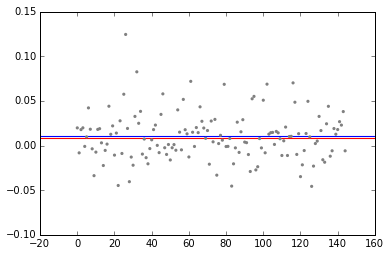

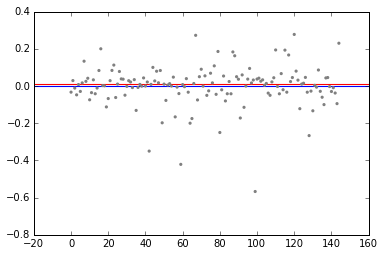

In [56]:
# ratings before/after
print 'all users rating avg'
rates_all = group_time_split(user_vals_split, 'review/overall', lambda x: float(x))
# want average reviews
rates_all = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_all)
avg_rates = []
for user in rates_all:
    user_avg = []
    for time in user:
        count, total, a = 0, 0, None
        for rating in time:
            count += rating[1]
            total += rating[0] * rating[1]
        if count > 0: 
            a = total/count
        user_avg.append(a) 
    avg_rates.append(user_avg)

# in the case of no review - rating is the same 
# TODO: how do we handle this
for user in avg_rates:
    for i, time in enumerate(user):
        if time is None:
            user[i] = user[abs(i-1)]
styles_plot = plot_diff(avg_rates)
print

print 'top users rating avg'
rates_top = group_time_split(users_top, 'review/overall', lambda x: float(x))
# want average reviews
rates_top = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_top)
avg_rates = []
for user in rates_top:
    user_avg = []
    for time in user:
        count, total, a = 0, 0, None
        for rating in time:
            count += rating[1]
            total += rating[0] * rating[1]
        if count > 0: 
            a = total/count
        user_avg.append(a) 
    avg_rates.append(user_avg)

for user in avg_rates:
    for i, time in enumerate(user):
        if time is None:
            user[i] = user[abs(i-1)]
styles_plot = plot_diff(avg_rates)
print

print 'sampled users rating avg'
rates_samp = group_time_split(users_sampled, 'review/overall', lambda x: float(x))
# want average reviews
rates_samp = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_samp)
avg_rates = []
for user in rates_samp:
    user_avg = []
    for time in user:
        count, total, a = 0, 0, None
        for rating in time:
            count += rating[1]
            total += rating[0] * rating[1]
        if count > 0: 
            a = total/count
        user_avg.append(a) 
    avg_rates.append(user_avg)

for user in avg_rates:
    for i, time in enumerate(user):
        if time is None:
            user[i] = user[abs(i-1)]
styles_plot = plot_diff(avg_rates)
print

In [309]:
# review lengths before/after
reviews = group_time_split(user_vals_split, 'review/text', lambda x: len(x.split()))
# want average length
rates = map(lambda x: [len(x[0].keys()), len(x[1].keys())], rates)

#repeat for sample, top